<a href="https://colab.research.google.com/github/cmr293/Data-Science-Project/blob/main/proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Phase II
Sydney Bednar sb844 and Chloe Reynolds cmr293

### Research Questions
1. To what extent is Uber driving out the NYC taxi business?
2. How does the choice of driving service vary geographically across New York City?

### Data Collection and Cleaning

**Uber Data**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
jan=pd.read_csv('january20_uber.csv')

In [ ]:
nov=pd.read_csv('nov19_uber.csv')

In [ ]:
sep=pd.read_csv('sep19_uber.csv')

These three data sets were pulled from the NYC Taxi & Limousine Commission website. They contain trip record data for high volume for-hire-vehicles in September and November 2019 and January 2020. We chose to focus on these three months so as not to look at patterns that may be due to COVID-19 but to keep the analysis as relevant as possible.

In [ ]:
uber_data=pd.concat([nov,jan,sep])
uber_data.head()

,Unnamed: 0,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,13525715,HV0003,B02867,2019-11-19 13:12:43,2019-11-19 13:54:53,205,162,NaN
1,12756495,HV0004,B02800,2019-11-18 09:16:31,2019-11-18 09:28:45,107,246,1.0
2,11386610,HV0003,B02883,2019-11-16 16:30:25,2019-11-16 16:42:09,90,249,1.0
3,16959294,HV0005,B02510,2019-11-23 23:48:16,2019-11-23 23:59:00,228,14,NaN
4,452235,HV0003,B02864,2019-11-01 16:26:07,2019-11-01 17:26:56,40,132,NaN


We first downloaded 3 months worth of Uber data from NYC and sampled 10,000 rows from each because the datasets are too large in scope. We then merged the datasets together to work on it more easily.

In [ ]:
uber_data=uber_data.drop(columns=['SR_Flag','dispatching_base_num','Unnamed: 0'])
uber_data=uber_data.rename(columns={'hvfhs_license_num':'service'})
uber_data=uber_data.loc[uber_data['service']=='HV0003'].reset_index(drop=True)
uber_data.loc[:,'service']='UBER'
uber_data.head()

,service,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
0,UBER,2019-11-19 13:12:43,2019-11-19 13:54:53,205,162
1,UBER,2019-11-16 16:30:25,2019-11-16 16:42:09,90,249
2,UBER,2019-11-01 16:26:07,2019-11-01 17:26:56,40,132
3,UBER,2019-11-22 21:33:29,2019-11-22 21:49:24,140,7
4,UBER,2019-11-25 19:21:09,2019-11-25 19:51:12,132,223


Because we are not interested in shared rides or dispatching bases, we deleted these columns and renamed the license number column to service. We also deleted the unnamed column that imported incorrectly into excel from the raw data. Based on the data description file for the raw data, the code HV003 corresponds to Uber, so we kept only the rows that were Uber rides as opposed to other for-hire-vehicles. Finally, to make it more clear, we renamed the license code 'HV003' to 'UBER' and reset the index of the dataframe.

In [ ]:
uber_data['pickup_datetime'] = pd.to_datetime(uber_data.pickup_datetime)
uber_data['dropoff_datetime'] = pd.to_datetime(uber_data.dropoff_datetime)
type(uber_data.pickup_datetime[0])


pandas._libs.tslibs.timestamps.Timestamp

In order to use this data effectively, we needed to convert the pickup and dropoff datetime into official datetime format rather than string format. 

**TLC Data**

We downloaded 3 months of yellow taxi data from NYC Taxi and Limousine Commission. They contain data from individual Taxi trips taken during that month. Since the total rows added up to over a million, we decided to sample 10,000 from each month in order to minimize data but also to not risk changing the ultimate effect of the data. We then converted these into a large dataset on an excel file in order to minimize computer storage and downloading time. We also chose this data based on the uber data available to match up the timing and months.

In [ ]:
TLC_data_prompt = 'TLC_data_excel.csv'
TLC_data = pd.read_csv(TLC_data_prompt)
TLC_data.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,5968249,2.0,2020-01-30 14:35:17,2020-01-30 15:36:03,2.0,13.13,2.0,N,125,132,1.0,52.0,0.0,0.5,11.06,0.0,0.3,66.36,2.5
1,1658155,1.0,2020-01-09 22:29:06,2020-01-09 23:18:56,1.0,16.10,1.0,N,114,259,1.0,52.0,3.0,0.5,13.90,0.0,0.3,69.70,2.5
2,512214,2.0,2020-01-03 23:59:35,2020-01-04 00:11:07,2.0,2.80,1.0,N,249,163,1.0,10.5,0.5,0.5,3.58,0.0,0.3,17.88,2.5
3,3792602,1.0,2020-01-20 08:52:19,2020-01-20 08:56:25,1.0,0.60,1.0,N,239,238,1.0,5.0,2.5,0.5,1.66,0.0,0.3,9.96,2.5
4,22986,2.0,2020-01-01 01:18:53,2020-01-01 01:26:11,1.0,1.31,1.0,N,107,158,2.0,7.0,0.5,0.5,0.00,0.0,0.3,10.80,2.5


We combined the monthly data into one data set so that it will be easier to work with.

In [ ]:
TLC_data = TLC_data.drop(columns=['Unnamed: 0','payment_type','RatecodeID','store_and_fwd_flag','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge'])
TLC_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,total_amount,congestion_surcharge
0,2.0,2020-01-30 14:35:17,2020-01-30 15:36:03,2.0,13.13,125,132,52.0,66.36,2.5
1,1.0,2020-01-09 22:29:06,2020-01-09 23:18:56,1.0,16.10,114,259,52.0,69.70,2.5
2,2.0,2020-01-03 23:59:35,2020-01-04 00:11:07,2.0,2.80,249,163,10.5,17.88,2.5
3,1.0,2020-01-20 08:52:19,2020-01-20 08:56:25,1.0,0.60,239,238,5.0,9.96,2.5
4,2.0,2020-01-01 01:18:53,2020-01-01 01:26:11,1.0,1.31,107,158,7.0,10.80,2.5


The dropped columns are removed as they are not useful to our research questions as well as they are not useful to use in connection with uber data. The Rate code ID has to do with rating of location, which is not applicable to our other data. Store and foward flag simply has to do with the driver's service connection, and the other removed columns are repetitive and not worthy for our data analysis. 

In [ ]:
TLC_data = TLC_data.rename(columns={'VendorID':'service','tpep_pickup_datetime':'pickup_datetime','tpep_dropoff_datetime':'dropoff_datetime'})
TLC_data = TLC_data.reset_index(drop=True)
TLC_data.loc[:,'service']='TLC'
TLC_data.head()

,service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,total_amount,congestion_surcharge
0,TLC,2020-01-30 14:35:17,2020-01-30 15:36:03,2.0,13.13,125,132,52.0,66.36,2.5
1,TLC,2020-01-09 22:29:06,2020-01-09 23:18:56,1.0,16.10,114,259,52.0,69.70,2.5
2,TLC,2020-01-03 23:59:35,2020-01-04 00:11:07,2.0,2.80,249,163,10.5,17.88,2.5
3,TLC,2020-01-20 08:52:19,2020-01-20 08:56:25,1.0,0.60,239,238,5.0,9.96,2.5
4,TLC,2020-01-01 01:18:53,2020-01-01 01:26:11,1.0,1.31,107,158,7.0,10.80,2.5


Vendor ID is a column that states where the data comes from, ranging from two NYC yellow taxi hubs. In our review of the data, both correspond to the yellow taxi data therefore, to make the data more legiable we will be renaming the values in this column 'TLC' and the column name 'service' as it will end up helping us down the line in using our data with other data. Also, we rename the data here in order to make it more comparable to uber data.

In [ ]:
TLC_data['pickup_datetime'] = pd.to_datetime(TLC_data.pickup_datetime)
TLC_data['dropoff_datetime'] = pd.to_datetime(TLC_data.dropoff_datetime)
type(TLC_data.dropoff_datetime[0])


  


pandas._libs.tslibs.timestamps.Timestamp

In order to use this data effectivly, we needed to convert the pickup and dropoff datetime into official datetime format rather than string format. 

**TLC Zone Map - Location ID**

### Data Description

* What are the observations (rows) and the attributes (columns)?

In [ ]:
uber_data.head()

,service,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
0,UBER,2019-11-19 13:12:43,2019-11-19 13:54:53,205,162
1,UBER,2019-11-16 16:30:25,2019-11-16 16:42:09,90,249
2,UBER,2019-11-01 16:26:07,2019-11-01 17:26:56,40,132
3,UBER,2019-11-22 21:33:29,2019-11-22 21:49:24,140,7
4,UBER,2019-11-25 19:21:09,2019-11-25 19:51:12,132,223


In [ ]:
TLC_data.head()

,service,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,total_amount,congestion_surcharge
0,TLC,2020-01-30 14:35:17,2020-01-30 15:36:03,2.0,13.13,125,132,52.0,66.36,2.5
1,TLC,2020-01-09 22:29:06,2020-01-09 23:18:56,1.0,16.10,114,259,52.0,69.70,2.5
2,TLC,2020-01-03 23:59:35,2020-01-04 00:11:07,2.0,2.80,249,163,10.5,17.88,2.5
3,TLC,2020-01-20 08:52:19,2020-01-20 08:56:25,1.0,0.60,239,238,5.0,9.96,2.5
4,TLC,2020-01-01 01:18:53,2020-01-01 01:26:11,1.0,1.31,107,158,7.0,10.80,2.5


Observations in these two datasets correspond to trips taken in NYC taxis or Ubers in September 2019, November 2019, and January 2020. Attributes for both datasets include the service, the pickup and dropoff date and time, the pickup location ID and the drop off location ID. The TLC dataset also includes the number of passengers, the trip distance, the fare amount, total amount for trip, and the congestion surcharge.

* Why was this dataset created?

Policy researchers at the NYC Taxi and Limousine Commission have compiled data from licensees in order to analyze changing trends in the industry and inform future City Council decisions.

* Who funded the creation of the dataset?

The NYC Taxi and Limousine Commision funded the creation of this dataset. Since this company is a NYC government agency, the NYC government is a part of the funding for all operations and data collection.

* What processes might have influenced what data was observed and recorded and what was not?

For Uber data, something that is likely not recorded is cancelled trips as well as extension of uber trips that are not recorded in uber data, where a driver might drop off a user somewhere else. Also, within our own processes with this data, we were unable to keep the same amount of rows of data between both TLC and uber data. For the TLC data, the information is tranferred to two different 'yellow taxi hubs' that then record and send the data to the NYC Taxi and Limousine Commission where they ubload it online. 

* What preprocessing was done, and how did the data come to be in the form that you are using?

Technology providers were authorized to pull this data from Uber and NYC taxi trips in order for us to work with this dataset.

* If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?

Both uber drivers and Yellow Taxi drivers are involved in this data as their pay and their liscenses are published. Through the nature of their job, they are hired with knowledge that their whereabouts, income per trip, and trip data will all be recorded for the sake of their companies through terms of agreement. In this case, yes they are aware of the data collection. They can expect their data to be used for the benefit of the company to be analyzed for both shareholders and those who are taking steps analyzing the data to improve the performance of the company.


* Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 

https://drive.google.com/drive/folders/1VKqfyS099EOuOWD2OW9Efi2Oh9_FkVS2?usp=sharing

### Data Limitations

Because we chose datasets pre-COVID, our results will not consider the impacts of COVID-19 on the industry as a whole. This limits the relativity of our data to today, it can still help us see different factors of the uber vs. yellow taxi fued in NYC.

Additionally, since we took random samples of each monthly dataset, there may not be an even range of times of day. Hopefully, since we used random there should be an even number, however time of day is a section of data we will be looking closely at, so any data that has been altered through our process of cleaning could be dangerous to our final results.

Another related data limitation is that the datasets are different sizes. TLC yellow taxi data is 30,000 rides while the total Uber data is only 21,000. This mean that the taxi data will be more accurate for thier time periods, and that it will be more difficult to compate statistics. 

Also, the data has no user information and therefore we are unable to see whats kinds of people (age, sex, etc) choose which kind of ride. The successfulness of a taxi or for hire vehicle business has a lot to do with the customer. What kind of customer picks one over the other? What trates of a customer can predict which ride they chose? This could be a large factor in the answer of our research questions, however that information is typically private so we are unable to use it. 

### Exploratory Data Analysis

In [ ]:
uber_pu_mode=uber_data.PULocationID.mode()
uber_do_mode=uber_data.DOLocationID.mode()
print("the most frequent uber pick-up location id: {:.0f}".format(int(uber_pu_mode)))
print("the most frequent uber drop-off location id: {:.0f}".format(int(uber_do_mode)))

the most frequent uber pick-up location id: 138
the most frequent uber drop-off location id: 265


Referring back to the taxi zone ID datasheet (see google drive folder), zone 138 corresponds to LaGuardia airport. We will look further into trends with airport pickups. Unfortunately, zone 265 corresponds to an unknown location. This could be due to the Uber app glitching or people asking for different drop off spots than they requested.

In [ ]:
TLC_pu_mode=TLC_data.PULocationID.mode()
TLC_do_mode=TLC_data.DOLocationID.mode()
print("the most frequent NYC Taxi pick-up location id: {:.0f}".format(int(TLC_pu_mode)))
print("the most frequent NYC Taxi drop-off location id: {:.0f}".format(int(TLC_do_mode)))

the most frequent NYC Taxi pick-up location id: 237
the most frequent NYC Taxi drop-off location id: 237


Zone 237 corresponds to Manhattan Upper East Side South, and this is the most frequent pick-up and drop-off location for NYC taxis. We will do further investigating into length of trips and car service chosen. We hypothesize that shorter trips tend to be taken in taxis while longer tend to be Ubers.

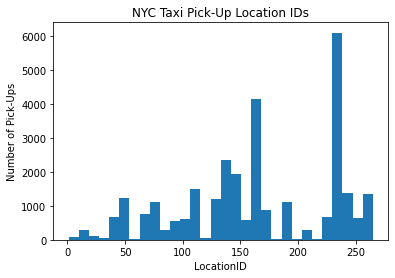

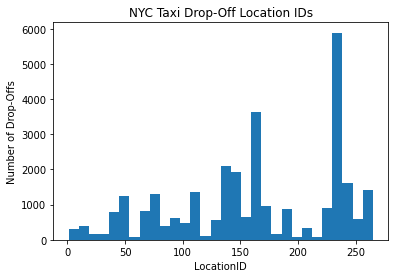

In [ ]:
# TLC pick up
plt.hist(TLC_data.PULocationID, bins=30)
plt.xlabel('LocationID')
plt.ylabel('Number of Pick-Ups')
plt.title('NYC Taxi Pick-Up Location IDs')
plt.show()

# TLC drop off
plt.hist(TLC_data.DOLocationID, bins=30)
plt.xlabel('LocationID')
plt.ylabel('Number of Drop-Offs')
plt.title('NYC Taxi Drop-Off Location IDs')
plt.show()
plt.show()

In [ ]:
print("the mean NYC Taxi trip distance: {:.2f} miles".format(TLC_data.trip_distance.mean()))

the mean NYC Taxi trip distance: 2.95 miles


Expanding on our above hypothesis, there is a very similar distribution of location IDs for pickups and drop offs, which could indicate shorter trips in taxis. Additionally,, the mean NYC Taxi trip distance was 2.95 miles. Since we do not have trip distances for the uber data set, we will begin to look at length in terms of time to make them comparable.

In [ ]:
# length=pd.DataFrame()
# length['uber']= uber_data.dropoff_datetime - uber_data.pickup_datetime
# length['tlc']= TLC_data.dropoff_datetime - TLC_data.pickup_datetime


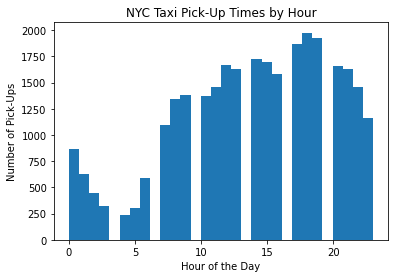

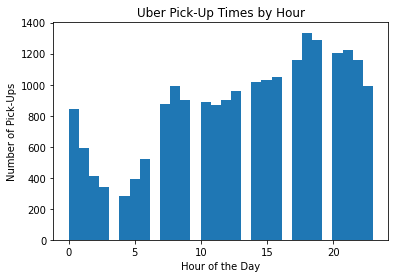

In [ ]:
# NYC Taxi
pu_time=[x.hour for x in TLC_data.pickup_datetime]
plt.hist(pu_time, bins=30)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pick-Ups')
plt.title('NYC Taxi Pick-Up Times by Hour')
plt.show()

# Uber
u_pu_time=[x.hour for x in uber_data.pickup_datetime]
plt.hist(u_pu_time, bins=30)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pick-Ups')
plt.title('Uber Pick-Up Times by Hour')
plt.show()

Comparing the two histograms, it appears that Uber and NYC Taxi have similar popular times of the day.

### Questions for Reviewers
1. Would it be better for us to combine the datasets or is it ok to leave them separate?
2. If we are using the location ID chart as a reference, should we be putting this in as data? 
3. What do you reccomend for ploting date/time graphs?
4. What more numerical data can we use?
5. Does any of the data suggest we should maybe edit our research questions?